## Описание проекта

Нам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются.


Описание полей данных
- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий), **целевой признак**
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

In [93]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik
import shap

# Импорт для разбивки и кодирования данных
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    # Разбиение данных
    train_test_split,

    # Случайный поиск
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    # Кодирование числовых значений
    StandardScaler,
    MinMaxScaler,
    RobustScaler,

    # Кодирование категориальных значение
    OneHotEncoder,
    LabelEncoder,
)

# Импорт для создания пайплайна
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей классификации
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Импорт метрик
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

# Импорт для кросс-валидации
from optuna.integration import OptunaSearchCV
from optuna import distributions

import logging
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

 ## Загрузка и проверка данных

In [94]:

# Импортируем тренировочный датасет
df = pd.read_csv('data/startup_train.csv',
                 parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

# Импортируем тестовый датасет
test_df = pd.read_csv('data/startup_test.csv',
                      parse_dates=['first_funding_at', 'last_funding_at'])

In [95]:
# Выводим информацию о тренировочном датасете
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT


Мы видим, что большинство данных у нас приведены к корректному типу данных. Мы можем привести столбец `status` к булевому типу, так как он принимает всего 2 значения: closed и operating. Сделаем это позже, используя label encoder. У нас в тренировочных данных присутствует столбец `closed_at`. Удалим его, так как это будет являться утечкой целевого признака

In [96]:
# Выводим информацию о тестовом датасете
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB
None


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386


В тестовом датасете данные все данные так же приведены к правильному типу данных. Столбец `lifetime` нам придется удалить, так как он не фигурирует в обучающих данных. Мы могли бы посчитать `lifetime` в тренировочной таблице, однако это будет утечкой целевого признака, так как для компаний, которые все еще не закрылись, данных не будет

### Вывод:

Мы видим, что большинство данных у нас приведены к корректному типу данных. Мы можем привести столбец `status` к булевому типу, так как он принимает всего 2 значения: closed и operating. Сделаем это позже, используя label encoder. У нас в тренировочных данных присутствует столбец `closed_at`. Удалим его, так как это будет являться утечкой целевого признака.

В тестовом датасете данные все данные так же приведены к правильному типу данных. Столбец `lifetime` нам придется удалить, так как он не фигурирует в обучающих данных. Мы могли бы посчитать `lifetime` в тренировочной таблице, однако это будет утечкой целевого признака, так как для компаний, которые все еще не закрылись, данных не будет


## Предобработка данных:

Посмотрим на наличие выбросов и пропусков. Обработаем их, если возможно

In [97]:
# Объявим список числовых, категориальных, и столбцов с датой
num_col_names = ['funding_total_usd', 'funding_rounds']
cat_col_names = ['category_list', 'country_code', 'state_code', 'region', 'city']
date_col_names = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

### Предобработка данных в тренировочном датасете

In [98]:
# Выводим информацию о пропусках и уникальных значениях
pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),

    'unique_count': df.nunique(),
    'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
})

,missing_count,missing_percent,unique_count,unique_percent
name,1,0.0,52515,100.0
category_list,2465,4.7,22105,42.1
funding_total_usd,10069,19.2,15551,29.6
status,0,0.0,2,0.0
country_code,5502,10.5,134,0.3
state_code,6763,12.9,300,0.6
region,6359,12.1,1036,2.0
city,6359,12.1,4477,8.5
funding_rounds,0,0.0,19,0.0
founded_at,0,0.0,5402,10.3


Рассмотрим столбцы, которые у нас есть
- `name` — в данном столбце у нас всего один пропуск, но эта это никак не повлияет на обучение модели, оставим все как есть
- `category_list` — в данном столбце у нас отсутствует 4.7% данных. Всего там 44% уникальных значений. Скорее всего пропуски в данном столбце мы заполним модой
- `funding_total_usd` — в данном столбце у нас отсутствует 19.2% данных. Так же по гистограмме видно, что там присутствуют выбросы. Рассмотрим это детальнее с помощью boxplot
- `status` — в данном столбце у нас представлен целевой признак. 90% компаний все еще работают, в то время как 10% компаний закрылись
- `country_code`— в данном столбце у нас отсутствует 10.5% данных. Всего там 134 уникальных значения. Пропуски мы заполним, медианным значением.
- `state_code`— в данном столбце у нас отсутствует 13% данных. Всего там 300 уникальных значений. Пропуски мы заполним медианным значением, предварительно сгруппировав данные по `county_code`
- `region`— в данном столбце у нас отсутствует 12% данных. Всего там 1036 уникальных значений. Пропуски мы заполним модой, сгруппировав `state_code`
- `city` — в данном столбце у нас отсутствует 12% данных. Всего там 4477 уникальных значений. Пропуски мы заполним модой, сгруппировав `city`
- `funding_rounds`— в данном столбце у нас нет пропусков, однако присутствуют выбросы. Рассмотрим это детальнее с помощью boxplot
- `founded_at` — в данном столбце у нас нет пропусков и выбросов. Гистограмма выглядит так, потому что в ранние годы либо было сильно меньше стартапов, либо их регистрация не фиксировалась
- `first_funding_at` — в данном столбце у нас аналогично предыдущему
- `last_funding_at` — в данном столбце у нас все аналогично предыдущему
- `closed_at` — в данном столбце у нас отсутствует 90% данных, но этот столбец понадобится нам только для исследовательского анализа

#### Обработка пропусков

Посмотрим, для каких значений у нас есть пропуски во всех категориях

In [99]:
# Посчитаем, количество строк, в которых присутствуют пропуски во всех столбцах одновременно
df[df['category_list'].isna() &
   df['funding_total_usd'].isna() &
   df['country_code'].isna() &
   df['state_code'].isna() &
   df['region'].isna() &
   df['city'].isna()
   ].shape[0]

884

Удалим эти столбцы, так как данные столбцы не будут нести какой-либо ценности для модели

In [100]:
# Удаляем строки, где пропуски во всех нижеперечисленных столбцах одновременно
df = df[~(df['category_list'].isna() &
          df['funding_total_usd'].isna() &
          df['country_code'].isna() &
          df['state_code'].isna() &
          df['region'].isna() &
          df['city'].isna())
]

# Проверяем, корректно ли мы все удалили
df[df['category_list'].isna() &
   df['funding_total_usd'].isna() &
   df['country_code'].isna() &
   df['state_code'].isna() &
   df['region'].isna() &
   df['city'].isna()
   ].shape[0]

0

Больше всего пропусков у нас в столбце `funding_total_usd`. Посмотрим, другие значения датасета с пропусками в данном столбца

In [101]:
df[df['funding_total_usd'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaT
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-03-11,2008-07-15,2008-07-15,NaT
34,Evargrah Entertainment Group,Entertainment|Games,NaN,operating,USA,CA,Los Angeles,Los Angeles,1,2013-08-13,2013-07-09,2013-07-09,NaT
35,Bibulu,Internet|Pets|Services,NaN,operating,ESP,56,Barcelona,Barcelona,1,2013-02-01,2013-03-01,2013-03-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaT
52502,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2007-04-28,2008-01-01,2008-01-01,NaT
52507,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaT
52508,ScramCard,NaN,NaN,operating,HKG,NaN,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaT


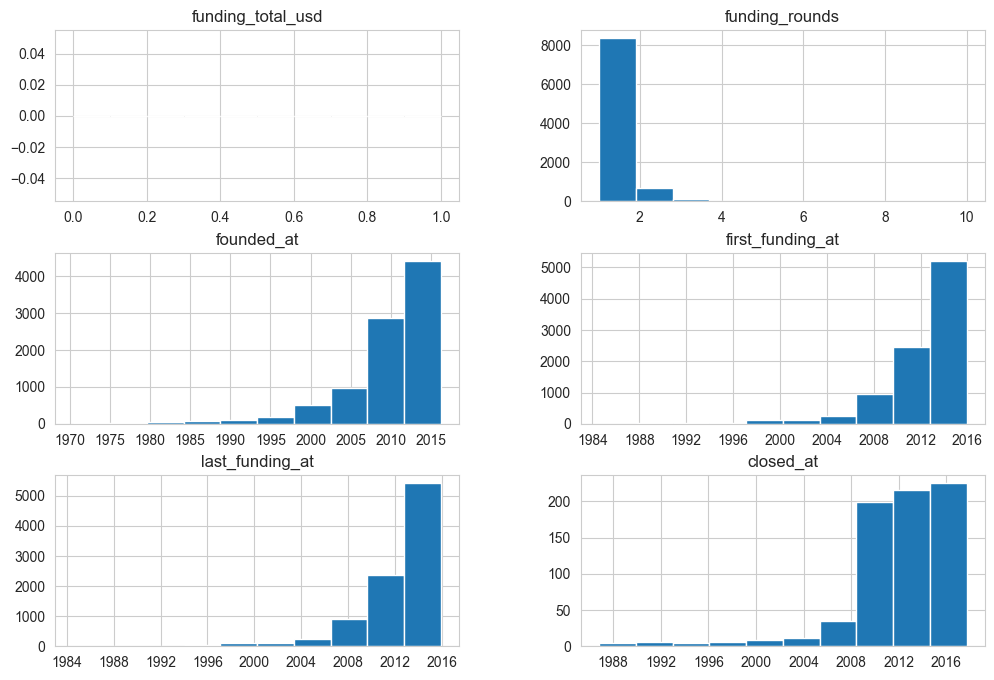

In [102]:
# Строим гистограмму для подобных столбцов
df[df['funding_total_usd'].isna()].hist(bins=10, figsize=(12, 8))
plt.show()

Мы видим, что в столбце `funding_rounds` превалирует значение в 1 раунд. Заполним пропуски в данном столбце нулями.

В категориальных же столбцах мы заполним все пропуски в категориальных столбцах значением `missing`

In [103]:
# Функция для заполнения пропусков
def fill_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    # заполняем числовые столбцы
    data['funding_total_usd'] = data['funding_total_usd'].fillna(0)

    # заполняем категориальные столбцы
    data['category_list'] = data['category_list'].fillna('missing')
    data['country_code'] = data['country_code'].fillna('missing')
    data['state_code'] = data['state_code'].fillna('missing')
    data['region'] = data['region'].fillna('missing')
    data['city'] = data['city'].fillna('missing')

    return data

In [104]:
# Удаляем пропуски в тренировочном датасете
df = fill_missing_values(df)

# Заполняем пропуски в closed_at датой
df['closed_at'] = df['closed_at'].fillna('2018-01-01')

#### Обработка выбросов

Посмотрим на выбросы, которые у нас есть в столбце `funding_total_usd`

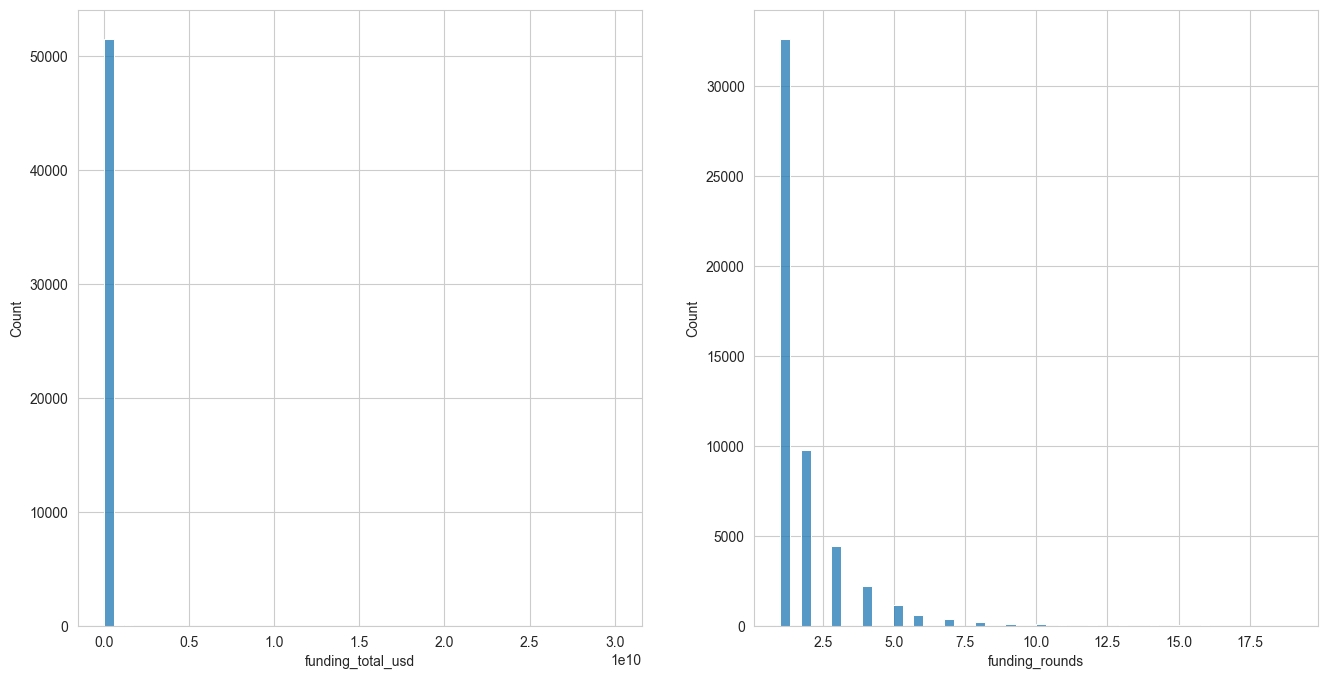

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Выводим гистограмму числовых значений
for i in range(len(num_col_names)):
    sns.histplot(data=df, x=num_col_names[i], bins=50, ax=axes[i])

plt.show()

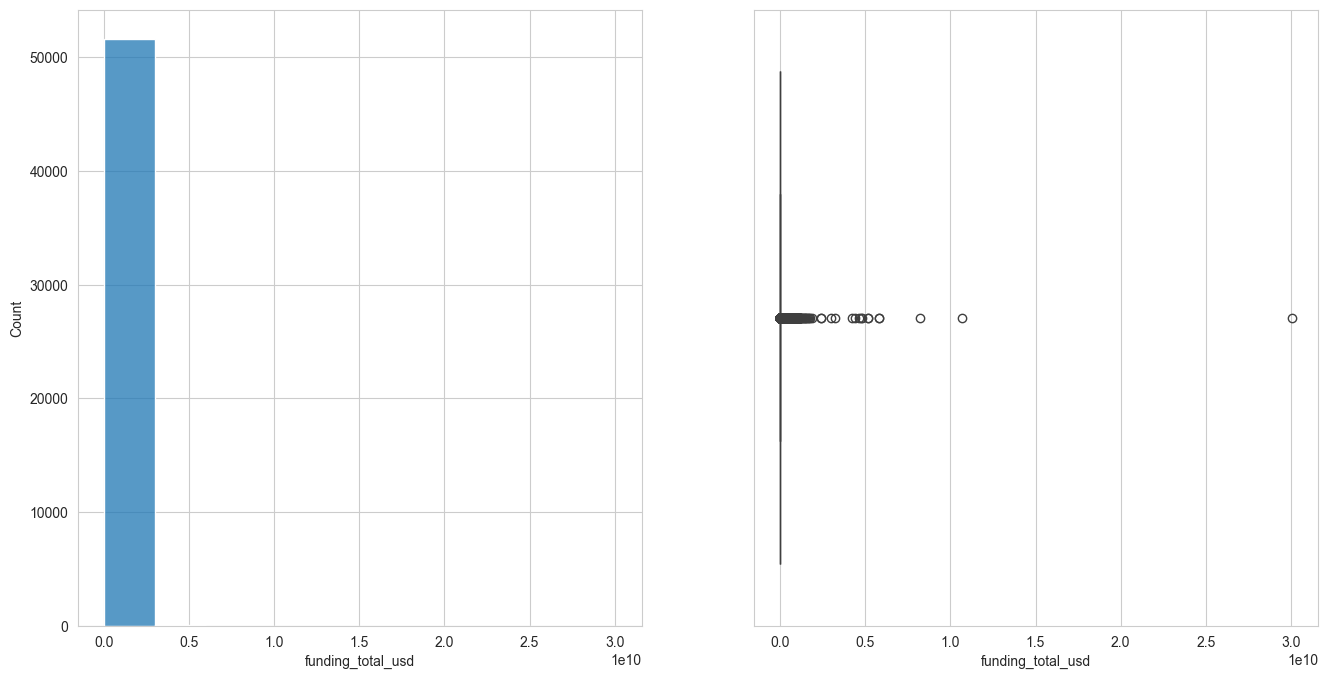

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.histplot(data=df, x='funding_total_usd', bins=10, ax=ax[0])
sns.boxplot(data=df, x='funding_total_usd', ax=ax[1])

plt.show()

Мы видим, что у нас присутствуют выбросы, которые вызваны даже если не вызваны ошибкой, то все равно помешают обучению модели. Остальные выбросы мы оставим, чтобы модель не обучалась в "идеальных" условиях. На первый взгляд, примерно 10-20 самых больших значений являются "критическими" выбросами. Посмотрим и удалим их

In [107]:
# Смотрим самые большие значение и количество раундов финансирования
df.sort_values(by=['funding_total_usd'], ascending=False)[['funding_total_usd', 'funding_rounds']]

,funding_total_usd,funding_rounds
39186,3.007950e+10,5
21241,1.066494e+10,1
4557,8.207450e+09,13
15976,5.820000e+09,6
36634,5.800000e+09,1
...,...,...
22100,0.000000e+00,2
10777,0.000000e+00,1
22101,0.000000e+00,1
46145,0.000000e+00,1


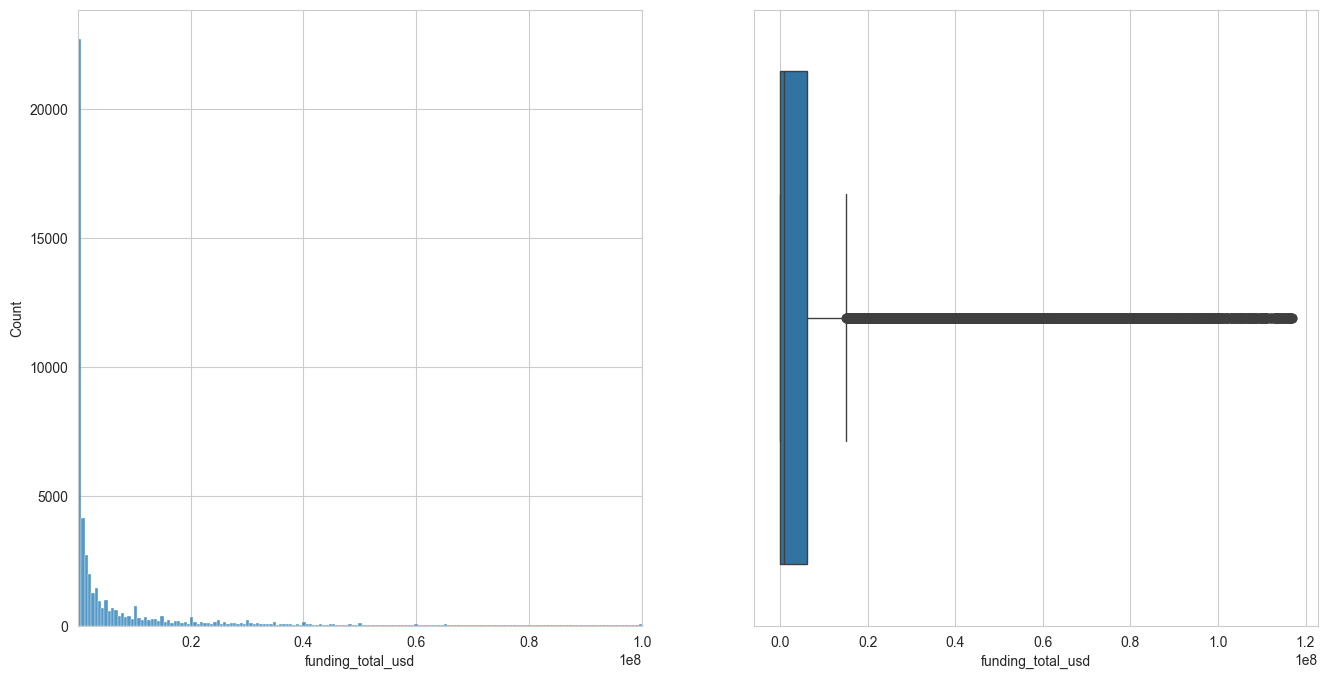

In [108]:
# Удаляем первые 30 самых больших значений
df = df.sort_values('funding_total_usd', ascending=False).iloc[1000:]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_xlim(1, 100000000)
sns.histplot(data=df, x='funding_total_usd', bins=200, ax=ax[0])

sns.boxplot(data=df, x='funding_total_usd', ax=ax[1])

plt.show()

#### Обработка дубликатов

In [109]:
# Проверяем наличие явных дубликатов
df.duplicated().sum()

0

In [110]:
# Проверяем наличие неявных дубликатов
df.drop('name', axis=1).duplicated().sum()

4

In [111]:
# Удаляем неявные дубликаты
df = df.drop_duplicates(subset=df.columns.difference(['name']))
df.drop('name', axis=1).duplicated().sum()

0

In [112]:
df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
44133,1stdibs,E-Commerce,117000000.0,operating,USA,NY,New York City,New York,5,2001-01-01,2011-11-03,2015-09-09,2018-01-01
6240,Affirmed Networks,Mobile,116990000.0,operating,USA,MA,Boston,Acton,5,2010-01-01,2010-06-18,2013-06-05,2018-01-01
33436,Trustpilot,Curated Web|Reputation|Reviews and Recommendat...,116900000.0,operating,DNK,17,Copenhagen,Copenhagen,5,2007-01-01,2011-01-28,2015-05-28,2018-01-01
43346,Integral Ad Science,Advertising|Big Data Analytics|Digital Media|I...,116750070.0,operating,USA,NY,New York City,New York,6,2009-01-01,2009-10-06,2015-07-31,2018-01-01
24146,Achaogen,Biotechnology|Health Care,116605707.0,operating,USA,CA,SF Bay Area,South San Francisco,4,2004-01-01,2004-08-01,2013-03-22,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100,InstaSafe,Network Security|Security,0.0,operating,IND,19,Bangalore,Bangalore,2,2012-10-01,2014-08-11,2015-08-26,2018-01-01
10777,Vital Juice Newsletter,Curated Web,0.0,operating,USA,NY,New York City,New York,1,2007-11-07,2009-01-29,2009-01-29,2018-01-01
22101,ensembli,Curated Web,0.0,operating,GBR,missing,missing,missing,1,2007-12-27,2009-03-03,2009-03-03,2018-01-01
46145,MSM Box,E-Commerce,0.0,operating,IND,7,Delhi,Delhi,1,2014-01-01,2015-08-17,2015-08-17,2018-01-01


In [113]:
pd.DataFrame(
    {'missing_total': df.isna().sum(),
     'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),
     'unique_count': df.nunique(),
     'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,1,0.0,50627,100.0
category_list,0,0.0,21775,43.0
funding_total_usd,0,0.0,14812,29.3
status,0,0.0,2,0.0
country_code,0,0.0,133,0.3
state_code,0,0.0,301,0.6
region,0,0.0,1034,2.0
city,0,0.0,4455,8.8
funding_rounds,0,0.0,18,0.0
founded_at,0,0.0,5314,10.5


Перед обработкой пропусков, мы удалили 30 самых больших значений в столбце `funding_total_usd`, потому что они бы сильно повлияли на обучение модели. Остальные выбросы мы оставили, чтобы модель не обучалась в "идеальных условиях"

Мы создали функцию для заполнения пропусков. Все пропуски были заполнены, основываясь на моде. Заполняли мы их, предварительно сгруппировав данные по "предыдущему столбцу"

### Предобработка в тестовом датасете

Обработаем пропуски аналогичным образом. Используем для этого ранее написанную функцию

In [114]:
pd.DataFrame(
    {'missing_total': test_df.isna().sum(),
     'missing_percent': round(test_df.isna().sum() / test_df.shape[0] * 100, 1),
     'unique_count': test_df.nunique(),
     'unique_percent': round(test_df.nunique() / test_df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,0,0.0,13125,100.0
category_list,591,4.5,6206,47.3
funding_total_usd,2578,19.6,4549,34.7
country_code,1382,10.5,96,0.7
state_code,1695,12.9,235,1.8
region,1589,12.1,688,5.2
city,1587,12.1,2117,16.1
funding_rounds,0,0.0,15,0.1
first_funding_at,0,0.0,3299,25.1
last_funding_at,0,0.0,3021,23.0


In [115]:
test_df = fill_missing_values(test_df)

In [116]:
pd.DataFrame(
    {'missing_total': test_df.isna().sum(),
     'missing_percent': round(test_df.isna().sum() / test_df.shape[0] * 100, 1),
     'unique_count': test_df.nunique(),
     'unique_percent': round(test_df.nunique() / test_df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,0,0.0,13125,100.0
category_list,0,0.0,6207,47.3
funding_total_usd,0,0.0,4550,34.7
country_code,0,0.0,97,0.7
state_code,0,0.0,236,1.8
region,0,0.0,689,5.2
city,0,0.0,2118,16.1
funding_rounds,0,0.0,15,0.1
first_funding_at,0,0.0,3299,25.1
last_funding_at,0,0.0,3021,23.0


### Вывод:

Во время предобработки данных мы создали функцию для удаления пропусков.

В тренировочном датасете мы удалили 30 самых больших значений. Остальные выбросы мы оставили.

В тестовом датасете мы обработали пропуски, используя функцию.

## Feature engineering

Проведем генерацию признаков: извлечем из дат год, месяц, и день. Так же сократим количество уникальных значений в категориальных столбцах: заменим значения, которые фигурируют мало раз на `other`. Для этого нам надо будет определить, какое значение считается "малым"

In [117]:
df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
44133,1stdibs,E-Commerce,117000000.0,operating,USA,NY,New York City,New York,5,2001-01-01,2011-11-03,2015-09-09,2018-01-01
6240,Affirmed Networks,Mobile,116990000.0,operating,USA,MA,Boston,Acton,5,2010-01-01,2010-06-18,2013-06-05,2018-01-01
33436,Trustpilot,Curated Web|Reputation|Reviews and Recommendat...,116900000.0,operating,DNK,17,Copenhagen,Copenhagen,5,2007-01-01,2011-01-28,2015-05-28,2018-01-01
43346,Integral Ad Science,Advertising|Big Data Analytics|Digital Media|I...,116750070.0,operating,USA,NY,New York City,New York,6,2009-01-01,2009-10-06,2015-07-31,2018-01-01
24146,Achaogen,Biotechnology|Health Care,116605707.0,operating,USA,CA,SF Bay Area,South San Francisco,4,2004-01-01,2004-08-01,2013-03-22,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100,InstaSafe,Network Security|Security,0.0,operating,IND,19,Bangalore,Bangalore,2,2012-10-01,2014-08-11,2015-08-26,2018-01-01
10777,Vital Juice Newsletter,Curated Web,0.0,operating,USA,NY,New York City,New York,1,2007-11-07,2009-01-29,2009-01-29,2018-01-01
22101,ensembli,Curated Web,0.0,operating,GBR,missing,missing,missing,1,2007-12-27,2009-03-03,2009-03-03,2018-01-01
46145,MSM Box,E-Commerce,0.0,operating,IND,7,Delhi,Delhi,1,2014-01-01,2015-08-17,2015-08-17,2018-01-01


In [118]:
# Создаем новые признаки в тренировочном датасете
df['funding_period'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
df['lifetime'] = (df['closed_at'] - df['founded_at']).dt.days
df['log_funding'] = np.log1p(df['funding_total_usd'])
df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_period,lifetime,log_funding
44133,1stdibs,E-Commerce,117000000.0,operating,USA,NY,New York City,New York,5,2001-01-01,2011-11-03,2015-09-09,2018-01-01,1406,6209,18.577685
6240,Affirmed Networks,Mobile,116990000.0,operating,USA,MA,Boston,Acton,5,2010-01-01,2010-06-18,2013-06-05,2018-01-01,1083,2922,18.577599
33436,Trustpilot,Curated Web|Reputation|Reviews and Recommendat...,116900000.0,operating,DNK,17,Copenhagen,Copenhagen,5,2007-01-01,2011-01-28,2015-05-28,2018-01-01,1581,4018,18.576829
43346,Integral Ad Science,Advertising|Big Data Analytics|Digital Media|I...,116750070.0,operating,USA,NY,New York City,New York,6,2009-01-01,2009-10-06,2015-07-31,2018-01-01,2124,3287,18.575546
24146,Achaogen,Biotechnology|Health Care,116605707.0,operating,USA,CA,SF Bay Area,South San Francisco,4,2004-01-01,2004-08-01,2013-03-22,2018-01-01,3155,5114,18.574309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100,InstaSafe,Network Security|Security,0.0,operating,IND,19,Bangalore,Bangalore,2,2012-10-01,2014-08-11,2015-08-26,2018-01-01,380,1918,0.000000
10777,Vital Juice Newsletter,Curated Web,0.0,operating,USA,NY,New York City,New York,1,2007-11-07,2009-01-29,2009-01-29,2018-01-01,0,3708,0.000000
22101,ensembli,Curated Web,0.0,operating,GBR,missing,missing,missing,1,2007-12-27,2009-03-03,2009-03-03,2018-01-01,0,3658,0.000000
46145,MSM Box,E-Commerce,0.0,operating,IND,7,Delhi,Delhi,1,2014-01-01,2015-08-17,2015-08-17,2018-01-01,0,1461,0.000000


In [119]:
# Создаем новые признаки в тестовом датасете
test_df['funding_period'] = (test_df['last_funding_at'] - test_df['first_funding_at']).dt.days
test_df['log_funding'] = np.log1p(test_df['funding_total_usd'])
test_df

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,funding_period,log_funding
0,Crystalsol,Clean Technology,2819200.0,NIC,17,missing,missing,1,2009-07-01,2009-07-01,3501,0,14.851964
1,JBI Fish & Wings,Hospitality,0.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,0,0.000000
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,126,12.967481
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,1935,17.362250
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,0,15.326233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267,0,10.239996
13121,GlobaTrek,Software,0.0,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192,0,0.000000
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922,1030,15.538277
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386,38,11.918397


In [120]:
# Словарь для категорий
manual_mapping = {
    # E-Commerce
    'e-commerce': 'E-Commerce',
    'marketplaces': 'E-Commerce',
    'payments': 'E-Commerce',
    'social commerce': 'E-Commerce',
    'mobile commerce': 'E-Commerce',
    'online shopping': 'E-Commerce',
    'retail technology': 'E-Commerce',
    'e-commerce platforms': 'E-Commerce',
    'logistics': 'E-Commerce',
    'shipping': 'E-Commerce',

    # Healthcare
    'health care': 'Healthcare',
    'medical devices': 'Healthcare',
    'mhealth': 'Healthcare',
    'pharmaceuticals': 'Healthcare',
    'medical': 'Healthcare',
    'hospitals': 'Healthcare',

    # Technology
    'technology': 'Technology',
    'cloud computing': 'Technology',
    'artificial intelligence': 'Technology',
    'machine learning': 'Technology',
    'enterprise software': 'Technology',
    'data security': 'Technology',
    'cyber security': 'Technology',
    'network security': 'Technology',
    'mobile': 'Technology',
    'saas': 'Technology',
    'software': 'Technology',
    'internet of things': 'Technology',
    'wearables': 'Technology',
    'image recognition': 'Technology',

    # Finance
    'finance': 'Finance',
    'fintech': 'Finance',
    'investment management': 'Finance',
    'wealth management': 'Finance',
    'financial services': 'Finance',
    'payments': 'Finance',

    # Education
    'education': 'Education',
    'edtech': 'Education',
    'online education': 'Education',
    'educational games': 'Education',

    # Marketing & Advertising
    'advertising': 'Marketing',
    'social media marketing': 'Marketing',
    'brand marketing': 'Marketing',
    'digital media': 'Marketing',
    'content': 'Marketing',

    # Logistics & Delivery
    'logistics': 'Logistics',
    'shipping': 'Logistics',
    'delivery': 'Logistics',

    # Security
    'security': 'Security',
    'data security': 'Security',
    'network security': 'Security',
    'cyber security': 'Security',

    # Media & Entertainment
    'media': 'Media',
    'entertainment': 'Media',
    'video streaming': 'Media',
    'music': 'Media',
    'games': 'Media',

    # Real Estate
    'real estate': 'Real Estate',
    'property management': 'Real Estate',

    # Travel & Hospitality
    'travel & tourism': 'Travel',
    'hospitality': 'Travel',
    'restaurants': 'Travel',

    # Manufacturing & Industrial
    'manufacturing': 'Manufacturing',
    'industrial': 'Manufacturing',

    # Energy
    'energy management': 'Energy',
    'renewable energies': 'Energy',

    # Agriculture
    'agriculture': 'Agriculture',

    # Automotive
    'cars': 'Automotive',
    'automotive': 'Automotive',

    # Nonprofits & Social
    'nonprofits': 'Nonprofits',
    'social media': 'Nonprofits',

    # Default rule
    'other': 'Other'
}

In [121]:
# Функция для извлечения года, месяца, дня
def extrat_date(col) -> tuple:
    year = col.year
    month = col.month
    day = col.day

    return year, month, day


# Функция для замены значений
def replace_rare_categories(df, thresholds):
    """
    Заменяет категории в столбцах на 'other', если их частота ниже порога.

    Аргументы:
    - df: pandas.DataFrame (датафрейм)
    - thresholds: dict (словарь в формате {столбец: порог})
    """
    for column, threshold in thresholds.items():
        # Подсчет частоты категорий
        value_counts = df[column].value_counts()

        # Создание маски для замены
        mask = df[column].map(value_counts) < threshold

        # Замена значений
        df[column] = df[column].mask(mask, 'other')

    return df

In [122]:
# Устанавливаем пороговое значение
threshold = 1000

country_code_top = df['country_code'].value_counts().index[:threshold].tolist()
state_code_top = df['state_code'].value_counts().index[:threshold].tolist()
region_top = df['region'].value_counts().index[:threshold].tolist()
city_top = df['city'].value_counts().index[:threshold].tolist()

### Feature engineering в тренировочном датафрейме

In [123]:
df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_period,lifetime,log_funding
44133,1stdibs,E-Commerce,117000000.0,operating,USA,NY,New York City,New York,5,2001-01-01,2011-11-03,2015-09-09,2018-01-01,1406,6209,18.577685
6240,Affirmed Networks,Mobile,116990000.0,operating,USA,MA,Boston,Acton,5,2010-01-01,2010-06-18,2013-06-05,2018-01-01,1083,2922,18.577599
33436,Trustpilot,Curated Web|Reputation|Reviews and Recommendat...,116900000.0,operating,DNK,17,Copenhagen,Copenhagen,5,2007-01-01,2011-01-28,2015-05-28,2018-01-01,1581,4018,18.576829
43346,Integral Ad Science,Advertising|Big Data Analytics|Digital Media|I...,116750070.0,operating,USA,NY,New York City,New York,6,2009-01-01,2009-10-06,2015-07-31,2018-01-01,2124,3287,18.575546
24146,Achaogen,Biotechnology|Health Care,116605707.0,operating,USA,CA,SF Bay Area,South San Francisco,4,2004-01-01,2004-08-01,2013-03-22,2018-01-01,3155,5114,18.574309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100,InstaSafe,Network Security|Security,0.0,operating,IND,19,Bangalore,Bangalore,2,2012-10-01,2014-08-11,2015-08-26,2018-01-01,380,1918,0.000000
10777,Vital Juice Newsletter,Curated Web,0.0,operating,USA,NY,New York City,New York,1,2007-11-07,2009-01-29,2009-01-29,2018-01-01,0,3708,0.000000
22101,ensembli,Curated Web,0.0,operating,GBR,missing,missing,missing,1,2007-12-27,2009-03-03,2009-03-03,2018-01-01,0,3658,0.000000
46145,MSM Box,E-Commerce,0.0,operating,IND,7,Delhi,Delhi,1,2014-01-01,2015-08-17,2015-08-17,2018-01-01,0,1461,0.000000


In [124]:
# Копируем датасет
df_processed = df.copy()

# Все значения, которые не в топе заменяем на other
df_processed.loc[~df_processed['country_code'].isin(country_code_top), 'country_code'] = 'other'
df_processed.loc[~df_processed['state_code'].isin(state_code_top), 'state_code'] = 'other'
df_processed.loc[~df_processed['region'].isin(region_top), 'region'] = 'other'
df_processed.loc[~df_processed['city'].isin(city_top), 'city'] = 'other'

# Выделяем главную категорию
df_processed['global_category'] = df_processed['category_list'].str.split('|').str[0]

# Разбиваем на год, месяц, день столбец first_funding_at
df_processed[['first_funding_at_year',
              'first_funding_at_month',
              'first_funding_at_day']] = df_processed['first_funding_at'].apply(extrat_date).apply(pd.Series)

# Разбиваем на год, месяц, день столбец last_funding_at
df_processed[['last_funding_at_year',
              'last_funding_at_month',
              'last_funding_at_day']] = df_processed['last_funding_at'].apply(extrat_date).apply(pd.Series)

# Избавляемся от ненужных столбцов
df_processed = df_processed.drop(['name', 'category_list',
                                  'first_funding_at', 'last_funding_at',
                                  'founded_at', 'closed_at'],
                                 axis=1)

In [125]:
# Выводим датасет после инженеринга
df_processed

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,funding_period,lifetime,log_funding,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
44133,117000000.0,operating,USA,NY,New York City,New York,5,1406,6209,18.577685,E-Commerce,2011,11,3,2015,9,9
6240,116990000.0,operating,USA,MA,Boston,Acton,5,1083,2922,18.577599,Mobile,2010,6,18,2013,6,5
33436,116900000.0,operating,DNK,17,Copenhagen,Copenhagen,5,1581,4018,18.576829,Curated Web,2011,1,28,2015,5,28
43346,116750070.0,operating,USA,NY,New York City,New York,6,2124,3287,18.575546,Advertising,2009,10,6,2015,7,31
24146,116605707.0,operating,USA,CA,SF Bay Area,South San Francisco,4,3155,5114,18.574309,Biotechnology,2004,8,1,2013,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100,0.0,operating,IND,19,Bangalore,Bangalore,2,380,1918,0.000000,Network Security,2014,8,11,2015,8,26
10777,0.0,operating,USA,NY,New York City,New York,1,0,3708,0.000000,Curated Web,2009,1,29,2009,1,29
22101,0.0,operating,GBR,missing,missing,missing,1,0,3658,0.000000,Curated Web,2009,3,3,2009,3,3
46145,0.0,operating,IND,7,Delhi,Delhi,1,0,1461,0.000000,E-Commerce,2015,8,17,2015,8,17


### Feature engineering в тестовом датасете

In [126]:
# Копируем датасет
test_df_processed = test_df.copy()

# Все значения, которые не в топе заменяем на other
test_df_processed.loc[~test_df_processed['country_code'].isin(country_code_top), 'country_code'] = 'other'
test_df_processed.loc[~test_df_processed['state_code'].isin(state_code_top), 'state_code'] = 'other'
test_df_processed.loc[~test_df_processed['region'].isin(region_top), 'region'] = 'other'
test_df_processed.loc[~test_df_processed['city'].isin(city_top), 'city'] = 'other'

# Сокращаем количество категорий
test_df_processed['global_category'] = test_df_processed['category_list'].str.split('|').str[0]

# Разбиваем на год, месяц, день столбец first_funding_at
test_df_processed[['first_funding_at_year',
                   'first_funding_at_month',
                   'first_funding_at_day']] = test_df_processed['first_funding_at'].apply(extrat_date).apply(pd.Series)

# Разбиваем на год, месяц, день столбец last_funding_at
test_df_processed[['last_funding_at_year',
                   'last_funding_at_month',
                   'last_funding_at_day']] = test_df_processed['last_funding_at'].apply(extrat_date).apply(pd.Series)

# Избавляемся от ненужных столбцов
test_df_processed = test_df_processed.drop(['name', 'category_list',
                                            'first_funding_at', 'last_funding_at'],
                                           axis=1)


In [127]:
test_df_processed

,funding_total_usd,country_code,state_code,region,city,funding_rounds,lifetime,funding_period,log_funding,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
0,2819200.0,NIC,17,missing,missing,1,3501,0,14.851964,Clean Technology,2009,7,1,2009,7,1
1,0.0,USA,TN,TN - Other,other,1,2717,0,0.000000,Hospitality,2010,7,28,2010,7,28
2,428257.0,LUX,3,Esch-sur-alzette,other,2,1295,126,12.967481,Finance,2014,5,15,2014,9,18
3,34700000.0,USA,CA,San Diego,San Diego,4,4748,1935,17.362250,Software,2005,1,1,2010,4,20
4,4530000.0,CAN,ON,Ottawa,Ottawa,1,6209,0,15.326233,Software,2007,5,8,2007,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2267,0,10.239996,Recruiting,2012,7,1,2012,7,1
13121,0.0,USA,CA,SF Bay Area,Mountain View,1,2192,0,0.000000,Software,2013,10,1,2013,10,1
13122,5600000.0,USA,WA,Seattle,Seattle,3,2922,1030,15.538277,Design,2008,9,1,2011,6,28
13123,150000.0,USA,NY,New York City,New York,2,1386,38,11.918397,Advertising Exchanges,2014,9,27,2014,11,4


In [128]:
# Смотрим различия в значениях столбцов между тренировочной и тестовой выборках
print(set(test_df_processed['country_code']) - set(df_processed['country_code']))
print(set(test_df_processed['state_code']) - set(df_processed['state_code']))
print(set(test_df_processed['region']) - set(df_processed['region']))
print(set(test_df_processed['city']) - set(df_processed['city']))
print(set(test_df_processed['global_category']) - set(df_processed['global_category']))

{'other'}
{'other'}
set()
set()
{'Experience Design', 'Homeless Shelter', 'Fmcg', 'Subscription Businesses', 'Private School', 'Social Buying', 'Mobile Shopping', 'GreenTech', 'Darknet', 'Senior Health', 'Testing', 'EDA Tools', 'Gay & Lesbian', 'Direct Advertising', 'Usability', 'Musicians', 'Vacation Rentals', 'Group Email', 'Real Estate Investors', 'Mens Specific'}


### Вывод

Мы написали 2 функции:
1. Функция, которая выделяет год, месяц, день из столбцов `first_funding_at`, `last_funding_at`. Столбец `founded_at` `closed_at` мы удалили из тренировочного датасета, так как их нет в тестовом датасете.
2. Функция, которая заменяет "малые" значения в категориальных столбцах на значение `other`. Пороги для замены мы оперделили, используя столбчатую диаграмму

Мы создали 2 новых датасета: `df_processed` и `test_df_processed`. В них мы избавились от лишних столбцов, которые не участвуют в обучении и предсказании модели, а так же применили к ним наши функции.

## Корреляционный анализ данных

In [129]:
df_processed

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,funding_period,lifetime,log_funding,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
44133,117000000.0,operating,USA,NY,New York City,New York,5,1406,6209,18.577685,E-Commerce,2011,11,3,2015,9,9
6240,116990000.0,operating,USA,MA,Boston,Acton,5,1083,2922,18.577599,Mobile,2010,6,18,2013,6,5
33436,116900000.0,operating,DNK,17,Copenhagen,Copenhagen,5,1581,4018,18.576829,Curated Web,2011,1,28,2015,5,28
43346,116750070.0,operating,USA,NY,New York City,New York,6,2124,3287,18.575546,Advertising,2009,10,6,2015,7,31
24146,116605707.0,operating,USA,CA,SF Bay Area,South San Francisco,4,3155,5114,18.574309,Biotechnology,2004,8,1,2013,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100,0.0,operating,IND,19,Bangalore,Bangalore,2,380,1918,0.000000,Network Security,2014,8,11,2015,8,26
10777,0.0,operating,USA,NY,New York City,New York,1,0,3708,0.000000,Curated Web,2009,1,29,2009,1,29
22101,0.0,operating,GBR,missing,missing,missing,1,0,3658,0.000000,Curated Web,2009,3,3,2009,3,3
46145,0.0,operating,IND,7,Delhi,Delhi,1,0,1461,0.000000,E-Commerce,2015,8,17,2015,8,17


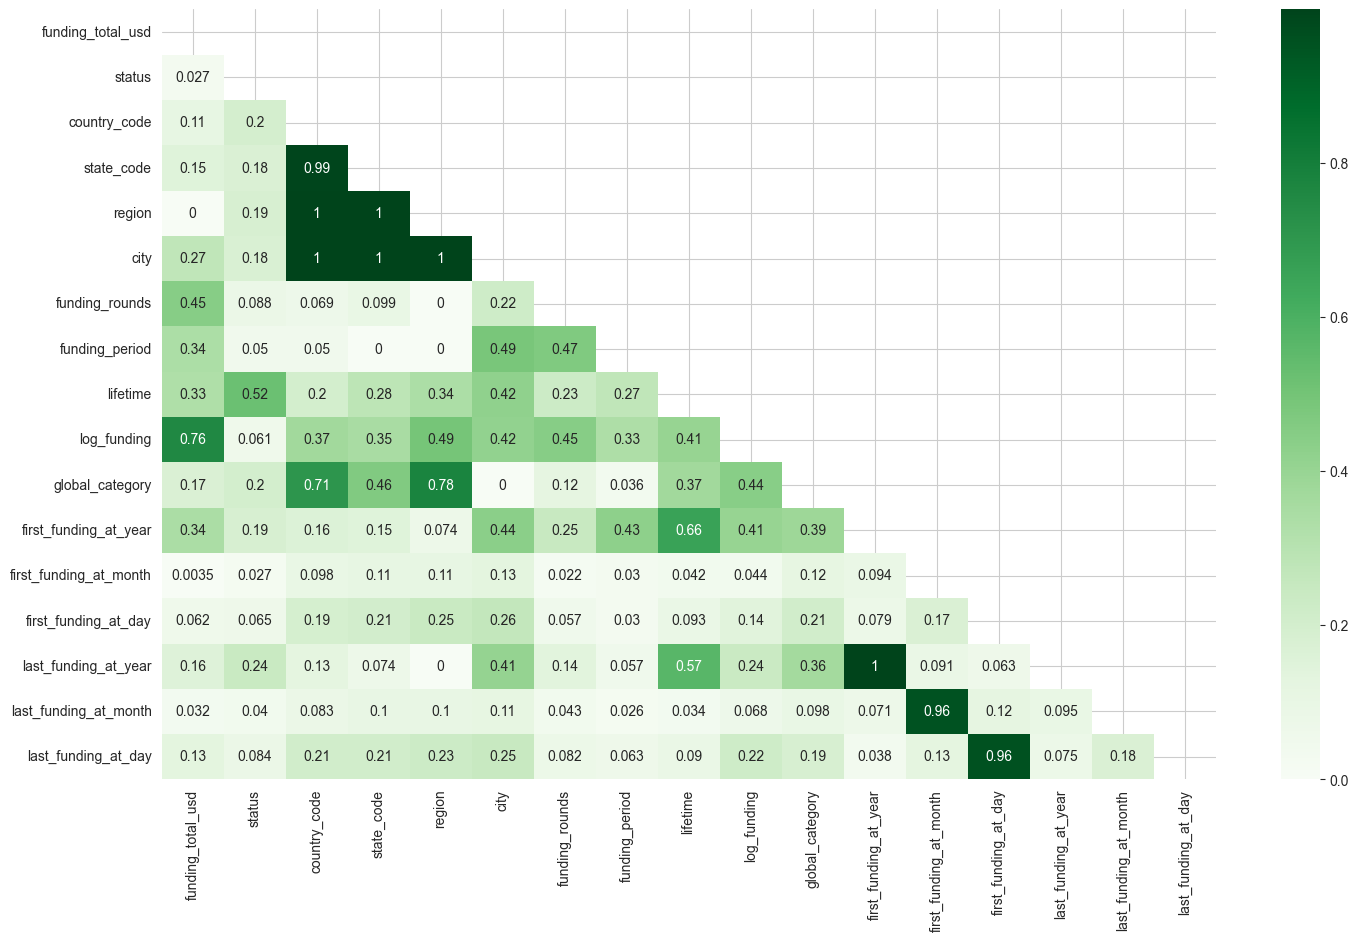

In [130]:
plt.figure(figsize=(17, 10))

ic = ['funding_rounds', 'funding_period', 'funding_total_usd', 'log_funding',
      'first_funding_at_year', 'first_funding_at_month', 'first_funding_at_day',
      'last_funding_at_year', 'last_funding_at_month', 'last_funding_at_day',
      'lifetime']
sns.heatmap(
    df_processed.phik_matrix(interval_cols=ic),
    annot=True, cmap='Greens',
    mask=(np.triu(
        np.ones_like(df_processed.phik_matrix(interval_cols=ic), dtype=bool)))
)

plt.show()

Мы видим, что у целевого признака невероятно маленькая корреляция с признаками `first_funding_at_month`, `first_funding_at_day`, `last_funding_at_month`, `last_funding_at_day`. Удалим их

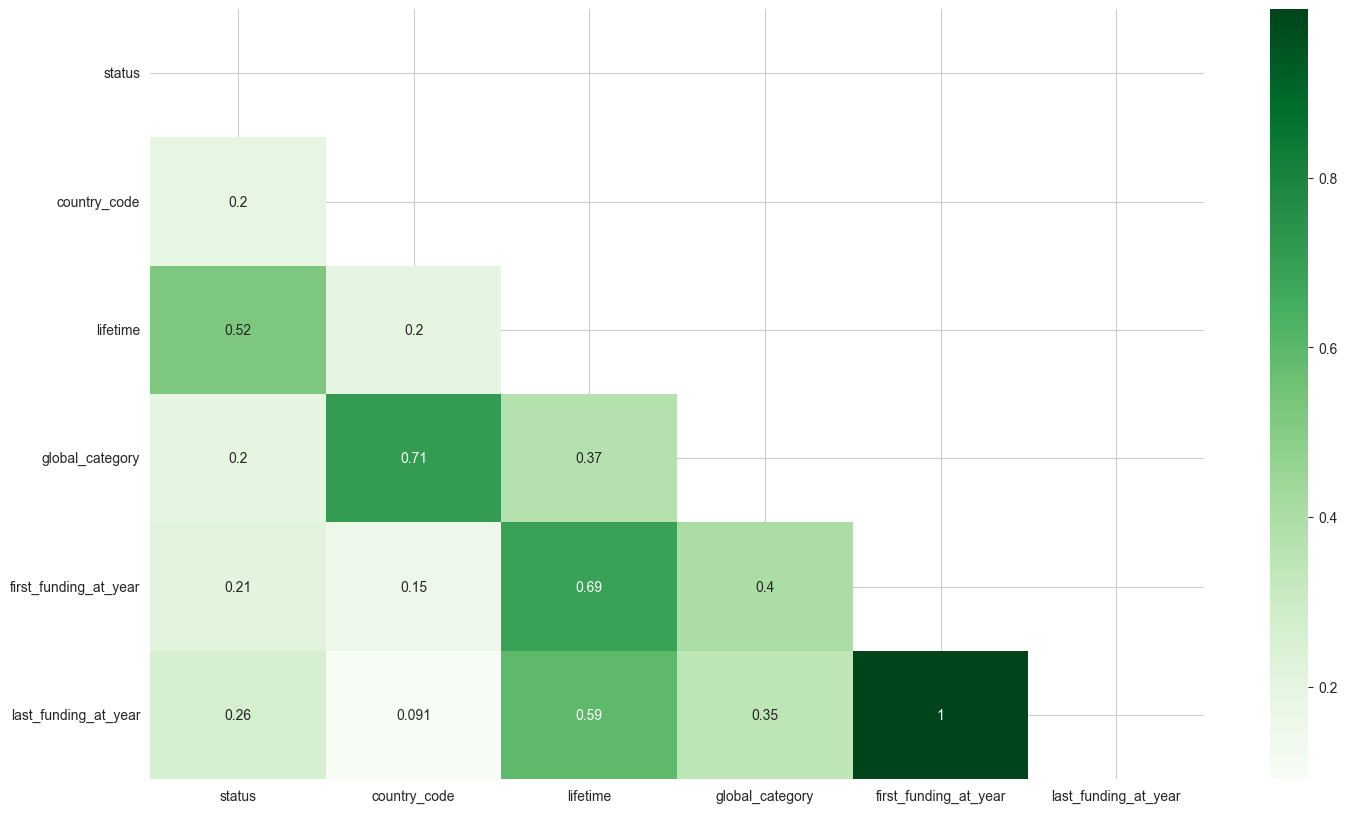

In [131]:
plt.figure(figsize=(17, 10))

# Удаляем ненужные столбцы
df_processed = df_processed.drop(['first_funding_at_day', 'first_funding_at_month',
                                  'last_funding_at_day', 'last_funding_at_month',
                                  'funding_total_usd', 'log_funding',
                                  'funding_period', 'funding_rounds',
                                  'city', 'region', 'state_code'],
                                 axis=1)
test_df_processed = test_df_processed.drop(['first_funding_at_day', 'first_funding_at_month',
                                            'last_funding_at_day', 'last_funding_at_month',
                                            'funding_total_usd', 'log_funding',
                                            'funding_period', 'funding_rounds',
                                            'city', 'region', 'state_code'],
                                           axis=1)

ic = ['lifetime']
sns.heatmap(
    df_processed.phik_matrix(
        interval_cols=ic),
    annot=True, cmap='Greens',
    mask=(np.triu(
        np.ones_like(df_processed.phik_matrix(interval_cols=ic), dtype=bool)))
)

plt.show()

Мы видим, у целевого признака `status` небольшая корреляция со всеми признаками. Наибольшая корреляция у него с годом первого и последнего спонсирования. Мы так же можем наблюдать мультиколлинеарность между всеми "географическими" столбцами, и `first_founded_at_year` вместе с `last_founded_at_year`. Однако это не помешает обучению модели, так что оставим все как есть


### Вывод:

Целовой признак не имеет высокой корреляции ни с одним из признаков. Столбцы `first_funding_at_month`, `first_funding_at_day`, `last_funding_at_month`, `last_funding_at_day` мы удалили, так как корреляция с целевым была ниже 0.1. Некоторые столбцы мультиколлинеарны, однако это не является для нас проблемой, так как мультиколлинеарности с целевым признаком нет.

## Исследовательский анализ

In [132]:
num_col_names = ['lifetime', 'first_funding_at_year', 'last_funding_at_year']
cat_col_names = ['country_code', 'global_category']

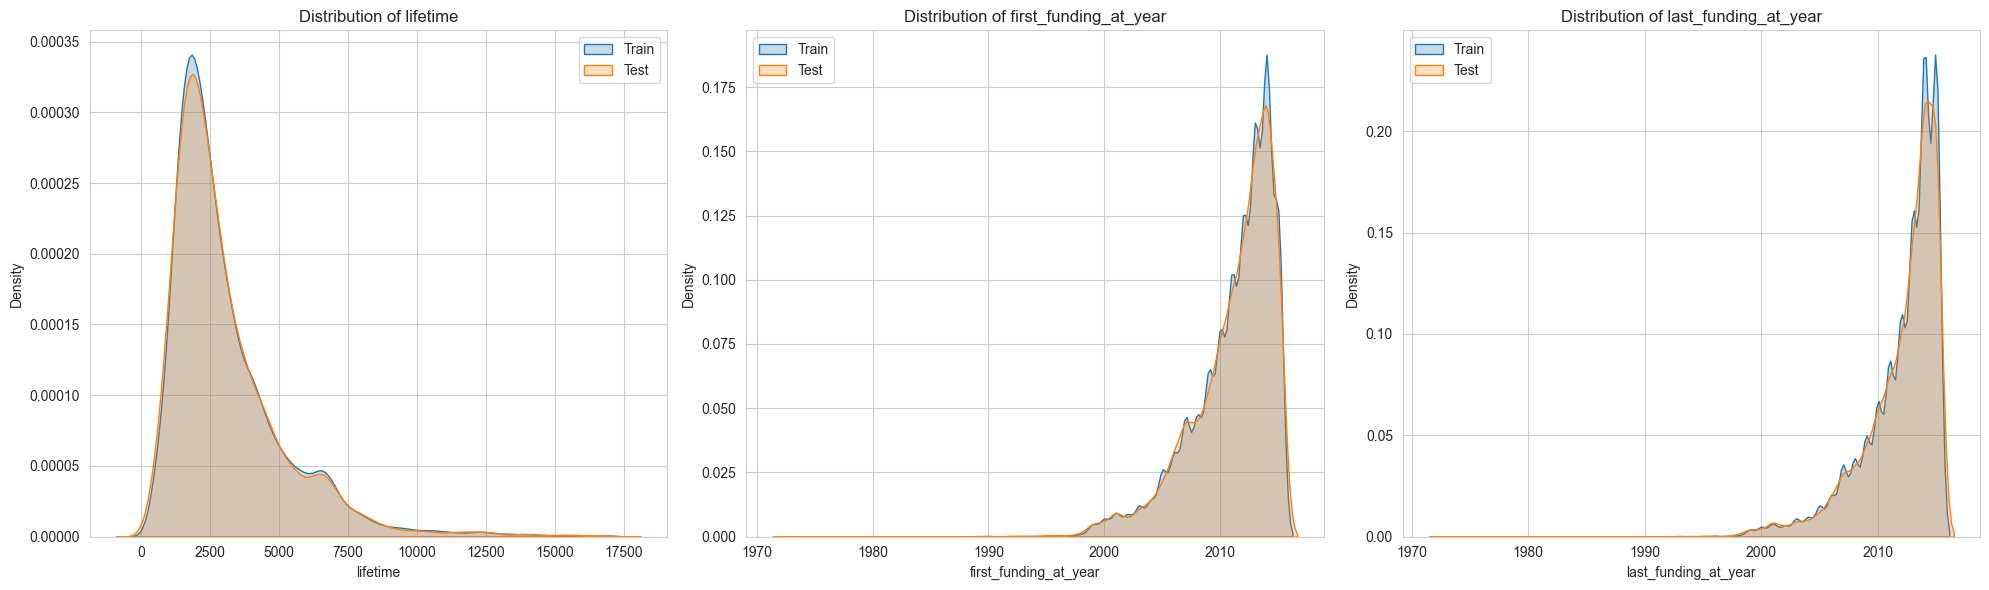

In [133]:
# Создаем фигуру с одной строкой и тремя столбцами
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Проходим по всем числовым признакам
for i, col in enumerate(num_col_names):
    # Строим KDE-графики для тренировочных и тестовых данных
    sns.kdeplot(df_processed[col], label='Train', fill=True, ax=axes[i])
    sns.kdeplot(test_df_processed[col], label='Test', fill=True, ax=axes[i])

    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()

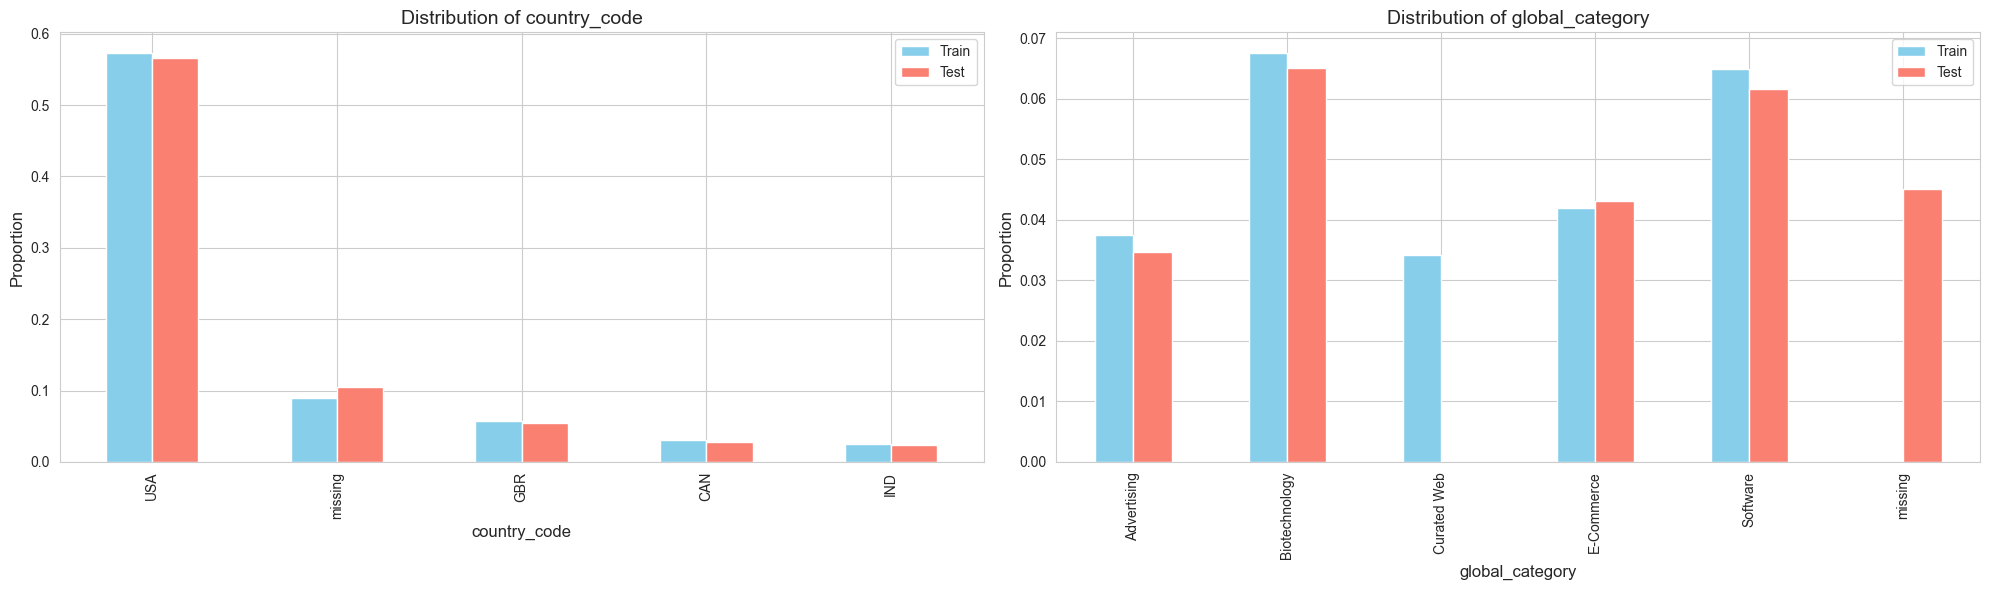

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Проходим по всем категориальным признакам
for i, feature in enumerate(cat_col_names):
    # Вычисляем нормализованные распределения
    train_dist = df_processed[feature].value_counts(normalize=True).head(5)
    test_dist = test_df_processed[feature].value_counts(normalize=True).head(5)

    # Объединяем данные для визуализации
    combined_dist = pd.DataFrame({
        'Train': train_dist,
        'Test': test_dist
    }).fillna(0)  # Заполняем отсутствующие категории нулями

    # Строим график
    combined_dist.plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].legend(['Train', 'Test'])

# Настройка макета
plt.tight_layout()
plt.show()

## Создание пайплайна

Соберем пайплайн для кодирования числовых и категориальных значений. Потом создадим сетку параметров для нашего пайплайна, и посмотрим на метрику, используя RandomizedSearchCV

In [135]:
set(df_processed.columns) - set(test_df_processed.columns)

{'status'}

In [136]:
# Определяем числовые и категориальные столбцы
num_col_names = ['lifetime', 'first_funding_at_year', 'last_funding_at_year']
cat_col_names = ['country_code', 'global_category']

# Пайплайн для числовых значений
num_pipeline = Pipeline([
    (
        'ImputerBeforeScaler',
        SimpleImputer(strategy='most_frequent', missing_values=np.nan)
    ),
    (
        'num',
        StandardScaler()
    )
])

# Пайплайн для категориальных значений
ohe_pipeline = Pipeline([
    (
        'OneHotEncoder',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )
])

# Собираем в один пайплайн по подготовке данных
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_col_names),
        ('ohe', ohe_pipeline, cat_col_names),
    ],
    remainder='passthrough',
)

# Собираем все в конечный пайплайн
final_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DummyClassifier(strategy='median')),
    ]
)

In [137]:
param_grid = [
    # Сетка параметров для логистической регрессии
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10, 100],
        'model__penalty': ['l2', 'none'],
        'model__max_iter': range(10, 1000),
        'model__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Сетка параметров для метода опорных векторов
    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__C': [0.1, 1, 10, 100],
        'model__degree': range(1, 11),
        'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'model__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Сетка параметров для метода ближайших соседей
    {
        'model': [KNeighborsClassifier(n_jobs=-1)],
        'model__n_neighbors': range(11, 21),
        'model__metric': ['minkowski', 'euclidean', 'manhattan'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    }
]

### Вывод:

Мы создали пайплайн и сетку гиперпараметров для 5-и моделей:
1. `Logistic Regression`
2. `SVC`
3. `KNeighborsClassifier`
4. `DecisionTreeClassifier`
5. `XGBClassifier`

## Обучение модели

Используем RandomizedSearchCV для подбора гиперпараметров

In [138]:
# Создаем RandomizedSearchCV для кросс-валидации
rs = RandomizedSearchCV(
    estimator=final_pipeline,
    param_distributions=param_grid,
    scoring='f1',
    n_jobs=-1,
    n_iter=20,
    cv=5,
    verbose=0,
    random_state=RANDOM_STATE,
)

In [139]:
X = df_processed.drop('status', axis=1)
y = df_processed['status']

# Разбиваем датафрейм на выборки
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size=0.25,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE)

# Объявляем label encoder
le = LabelEncoder()

# Обучаем энкодер
y_train = le.fit_transform(y_train)
# Проставляем классы: 'closed' = 0, 'operating' = 1
le.classes_ = np.array(['closed', 'operating'])
# Кодируем данные в валидационной выборке
y_valid = le.transform(y_valid)

In [140]:
X_train

,country_code,lifetime,global_category,first_funding_at_year,last_funding_at_year
9193,USA,6575,Analytics,2005,2005
48960,USA,1826,Android,2015,2015
16483,IND,1938,News,2013,2013
9320,IND,2084,E-Commerce,2014,2014
34717,missing,1175,E-Commerce,2014,2014
...,...,...,...,...,...
15791,USA,2557,Big Data,2011,2014
39828,EGY,2618,Banking,2011,2014
23259,SWE,2701,Software,2012,2012
16393,RUS,1739,Music,2013,2013


In [141]:
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

# Обучаем модель
rs.fit(X_train, y_train)

/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found un

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('ImputerBeforeScaler',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('num',
                                                                                                StandardScaler())]),
                                                                               ['lifetime',
                                                                                'first_funding_at_year',
                                                                                'last_funding_at_year']),
                                                                              ('ohe',
                                                                               Pipeline(steps=[('OneHotEncoder',
                                                                                                OneHotEncoder...
                                         'model__kernel': ['linear', 'rbf',
                                                           'poly', 'sigmoid'],
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'model': [KNeighborsClassifier(n_jobs=-1)],
                                         'model__metric': ['minkowski',
                                                           'euclidean',
                                                           'manhattan'],
                                         'model__n_neighbors': range(11, 21),
                                         'preprocessor__num': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='f1')

In [142]:
# Выводим метрику на тренировочной выборке
print('f1_score:', round(rs.best_score_, 5))

f1_score: 0.96481


In [143]:
rs.best_params_

{'preprocessor__num': StandardScaler(),
 'model__penalty': 'l2',
 'model__max_iter': 793,
 'model__class_weight': 'balanced',
 'model__C': 0.1,
 'model': LogisticRegression(random_state=42)}

In [144]:
# Создаем датафрейм с истинным статусом, вероятностью, и предсказанием
predictions = pd.DataFrame({
    'actual': y_valid,
    'rs_proba': rs.best_estimator_.predict_proba(X_valid)[:, 1],
})

### XGBClassifier

In [145]:
X_train_transformed = data_preprocessor.fit_transform(X_train)
X_valid_transformed = data_preprocessor.transform(X_valid)

In [146]:
# Определение сетки гиперпараметров
xgbc_params = {
    'n_estimators': distributions.IntDistribution(100, 500, step=50),  # Количество деревьев
    'max_depth': distributions.IntDistribution(3, 10),  # Максимальная глубина дерева
    'learning_rate': distributions.FloatDistribution(0.01, 0.3, log=True),  # Скорость обучения
    'subsample': distributions.FloatDistribution(0.6, 1.0),  # Доля выборки для обучения каждого дерева
    'colsample_bytree': distributions.FloatDistribution(0.6, 1.0),  # Доля признаков для каждого дерева
    'reg_alpha': distributions.FloatDistribution(0, 1.0),  # L1-регуляризация
    'reg_lambda': distributions.FloatDistribution(0, 1.0),  # L2-регуляризация
    'min_child_weight': distributions.IntDistribution(1, 10),  # Минимальный вес для создания нового узла
    'gamma': distributions.FloatDistribution(0, 1.0),  # Минимальное снижение потерь для создания нового узла
}

# Создаем OptunaSearchCV
xgbc_optuna_cv = OptunaSearchCV(
    estimator=XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        objective='binary:logistic',  # Фиксированное значение для бинарной классификации
        eval_metric='logloss'  # Метрика для оценки качества модели
    ),
    param_distributions=xgbc_params,
    scoring='f1',  # Метрика для оптимизации
    n_trials=10,  # Количество испытаний
    cv=5,  # Кросс-валидация
    n_jobs=-1,  # Использование всех ядер
    verbose=0,
)

# Отключаем логи Optuna
# optuna_logger = logging.getLogger("optuna")
# optuna_logger.setLevel(logging.CRITICAL)

# Обучаем модель
xgbc_optuna_cv.fit(X_train_transformed, y_train)

[I 2025-04-06 19:11:55,245] A new study created in memory with name: no-name-0b97446e-8a93-44f6-a74a-7b5fcc76b5c7
[I 2025-04-06 19:12:12,357] Trial 2 finished with value: 0.9859241079893504 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.020312162675115646, 'subsample': 0.7792955095214544, 'colsample_bytree': 0.6235854537881959, 'reg_alpha': 0.16365621118436946, 'reg_lambda': 0.858011826337634, 'min_child_weight': 1, 'gamma': 0.8358844947679501}. Best is trial 2 with value: 0.9859241079893504.
[I 2025-04-06 19:12:15,368] Trial 3 finished with value: 0.9884368000456174 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.18225349100974197, 'subsample': 0.9080275659719991, 'colsample_bytree': 0.9011576959996932, 'reg_alpha': 0.9226351489282217, 'reg_lambda': 0.9497778718992519, 'min_child_weight': 3, 'gamma': 0.5136850179546664}. Best is trial 3 with value: 0.9884368000456174.
[I 2025-04-06 19:12:19,883] Trial 9 finished with value: 0.98809264

OptunaSearchCV(cv=5,
               estimator=XGBClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric='logloss',
                                       feature_types=None, feature_weights=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constrai...
                                    'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1),
                                    'n_estimators': IntDistribution(high=500, log=False, low=100, step=50),
                                    'reg_alpha': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'reg_lambda': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None)},
               scoring='f1')

In [147]:
print("Лучшие параметры:", xgbc_optuna_cv.best_params_)
print("Лучший F1-score:", xgbc_optuna_cv.best_score_)

Лучшие параметры: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.18225349100974197, 'subsample': 0.9080275659719991, 'colsample_bytree': 0.9011576959996932, 'reg_alpha': 0.9226351489282217, 'reg_lambda': 0.9497778718992519, 'min_child_weight': 3, 'gamma': 0.5136850179546664}
Лучший F1-score: 0.9884368000456174


In [207]:
predictions['xgbc_proba'] = xgbc_optuna_cv.best_estimator_.predict_proba(X_valid_transformed)[:, 1]
predictions

,actual,rs_proba,xgbc_proba,catboost_proba,rs_prediction,xgbc_prediction,catboost_prediction
0,1,0.733804,0.996542,0.989284,0,0,0
1,1,0.713154,0.979736,0.982062,0,0,0
2,1,0.496126,0.675840,0.777857,0,0,0
3,1,0.744228,0.993224,0.988153,0,0,0
4,1,0.647827,0.972608,0.989010,0,0,0
...,...,...,...,...,...,...,...
12652,1,0.684863,0.997661,0.991154,0,0,0
12653,1,0.822460,0.999202,0.991622,0,0,0
12654,1,0.820629,0.960342,0.988325,0,0,0
12655,1,0.750237,0.991309,0.958364,0,0,0


### Catboost

In [208]:
# Определение сетки гиперпараметров
catboost_params = {
    'iterations': distributions.IntDistribution(100, 1000, step=50),  # Количество итераций (деревьев)
    'learning_rate': distributions.FloatDistribution(0.01, 0.3, log=True),  # Скорость обучения
    'depth': distributions.IntDistribution(4, 10),  # Глубина каждого дерева
    'l2_leaf_reg': distributions.FloatDistribution(1e-8, 100, log=True),  # L2-регуляризация
    'bagging_temperature': distributions.FloatDistribution(0.0, 1.0),  # Температура бэггинга
    'random_strength': distributions.FloatDistribution(1e-8, 10, log=True),  # Сила случайности при выборе разбиений
    'border_count': distributions.IntDistribution(32, 255),  # Количество разбиений для числовых признаков
    'grow_policy': distributions.CategoricalDistribution(['SymmetricTree', 'Depthwise', 'Lossguide']),
    # Стратегия роста деревьев
    'auto_class_weights': distributions.CategoricalDistribution(['None', 'Balanced', 'SqrtBalanced']),
    # Автоматическая балансировка классов
}

# Создаем OptunaSearchCV
catboost_optuna_cv = OptunaSearchCV(
    estimator=CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=False,  # Отключаем вывод логов CatBoost
        thread_count=-1  # Используем все доступные ядра
    ),
    param_distributions=catboost_params,
    scoring='f1',  # Метрика для оптимизации
    n_trials=15,  # Количество испытаний
    cv=5,  # Кросс-валидация
    n_jobs=-1,  # Использование всех ядер
    verbose=0,
)

# Запускаем поиск гиперпараметров
catboost_optuna_cv.fit(X_train, y_train, cat_features=cat_col_names)

[I 2025-04-06 19:36:20,104] A new study created in memory with name: no-name-f369cb62-14e9-48d0-a63a-8ff6110b5ac4
Training has stopped (degenerate solution on iteration 16, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 27, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 42, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 60, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 137, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 26, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 12, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 86, probabl

OptunaSearchCV(cv=5,
               estimator=<catboost.core.CatBoostClassifier object at 0x1768cbb90>,
               n_jobs=-1, n_trials=15,
               param_distributions={'auto_class_weights': CategoricalDistribution(choices=('None', 'Balanced', 'SqrtBalanced')),
                                    'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'border_count': IntDistribution(high=255, log=False, low=32...
                                    'grow_policy': CategoricalDistribution(choices=('SymmetricTree', 'Depthwise', 'Lossguide')),
                                    'iterations': IntDistribution(high=1000, log=False, low=100, step=50),
                                    'l2_leaf_reg': FloatDistribution(high=100.0, log=True, low=1e-08, step=None),
                                    'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None),
                                    'random_strength': FloatDistribution(high=10.0, log=True, low=1e-08, step=None)},
               scoring='f1')

In [209]:
print("Лучшие параметры:", catboost_optuna_cv.best_params_)
print("Лучший F1-score:", catboost_optuna_cv.best_score_)

Лучшие параметры: {'iterations': 1000, 'learning_rate': 0.010469176417096524, 'depth': 8, 'l2_leaf_reg': 0.0065849648339487395, 'bagging_temperature': 0.27123387080587535, 'random_strength': 4.545085165271485e-05, 'border_count': 84, 'grow_policy': 'Lossguide', 'auto_class_weights': 'None'}
Лучший F1-score: 0.9882165609813149


In [210]:
predictions['catboost_proba'] = catboost_optuna_cv.best_estimator_.predict_proba(X_valid)[:, 1]
predictions

,actual,rs_proba,xgbc_proba,catboost_proba,rs_prediction,xgbc_prediction,catboost_prediction
0,1,0.733804,0.996542,0.993078,0,0,0
1,1,0.713154,0.979736,0.987925,0,0,0
2,1,0.496126,0.675840,0.850312,0,0,0
3,1,0.744228,0.993224,0.986420,0,0,0
4,1,0.647827,0.972608,0.982203,0,0,0
...,...,...,...,...,...,...,...
12652,1,0.684863,0.997661,0.991055,0,0,0
12653,1,0.822460,0.999202,0.993323,0,0,0
12654,1,0.820629,0.960342,0.989192,0,0,0
12655,1,0.750237,0.991309,0.979334,0,0,0


### Изменение порогов

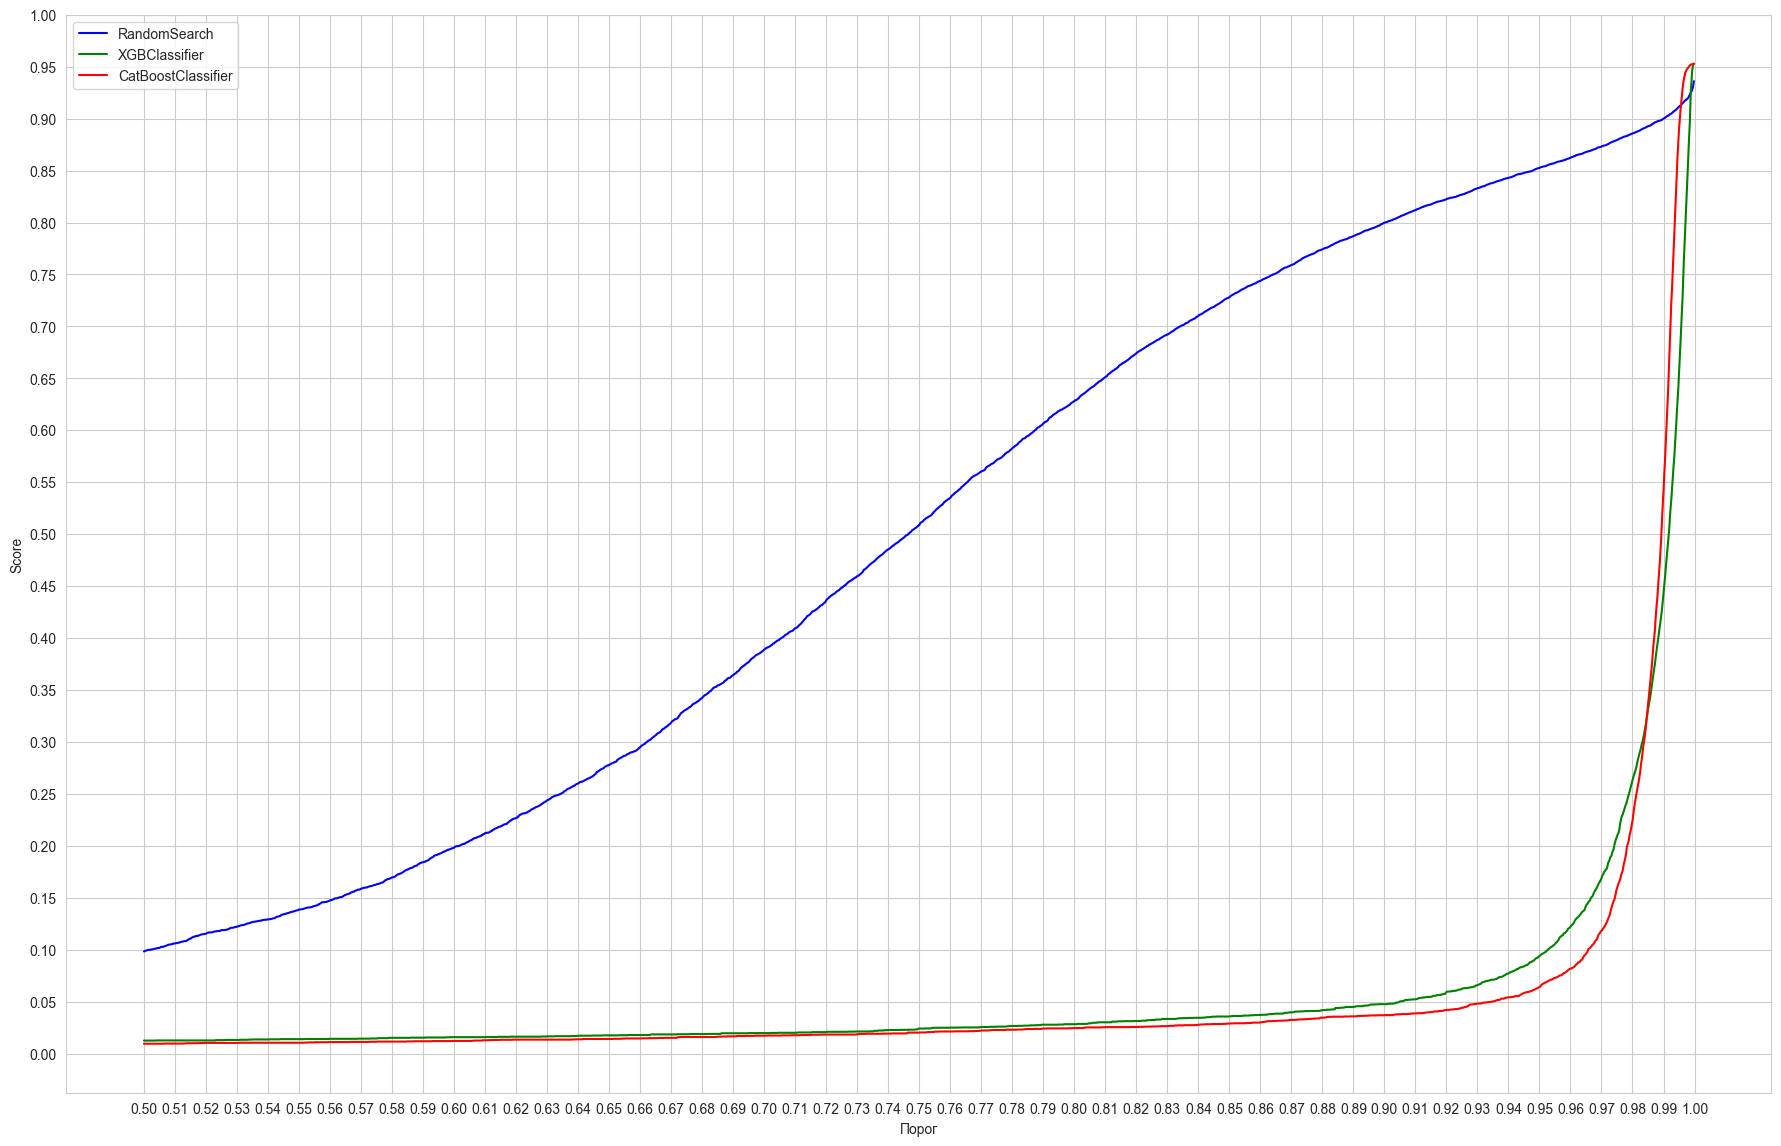

In [211]:
proba_threshold = [round(i, 4) for i in np.linspace(0.5, 1, num=2000, endpoint=False)]

# Создаем массивы порогов и результатов метрики f1
thresholds = []
rs_scores = []
xgbc_scores = []
catboost_scores = []

# Изменяем порог
for i in proba_threshold:
    predictions['rs_prediction'] = predictions['rs_proba'].apply(lambda x: 1 if x < i else 0)
    predictions['xgbc_prediction'] = predictions['xgbc_proba'].apply(lambda x: 1 if x < i else 0)
    predictions['catboost_prediction'] = predictions['catboost_proba'].apply(lambda x: 1 if x < i else 0)

    thresholds.append(i)

    rs_scores.append(f1_score(predictions['actual'], predictions['rs_prediction']))
    xgbc_scores.append(f1_score(predictions['actual'], predictions['xgbc_prediction']))
    catboost_scores.append(f1_score(predictions['actual'], predictions['catboost_prediction']))

fig, ax = plt.subplots(figsize=(22, 14))

sns.lineplot(x=thresholds, y=rs_scores,
             legend=True, label='RandomSearch',
             color='blue', ax=ax)
sns.lineplot(x=thresholds, y=xgbc_scores,
             label='XGBClassifier',
             color='green', ax=ax)
sns.lineplot(x=thresholds, y=catboost_scores,
             label='CatBoostClassifier',
             color='red', ax=ax)

ax.set_ylabel('Score')
ax.set_yticks(np.arange(0, 1.01, 0.05))

ax.set_xlabel('Порог')
ax.set_xticks(np.arange(0.5, 1.01, 0.01))

plt.show()
# plt.title('Зависимость потерь в млн рублей от выбранного порога');

Лучшие пороги и F1-score:
RandomSearch: порог = 0.5000, F1 = 0.9644
XGBClassifier: порог = 0.5065, F1 = 0.9888
CatBoostClassifier: порог = 0.5155, F1 = 0.9891


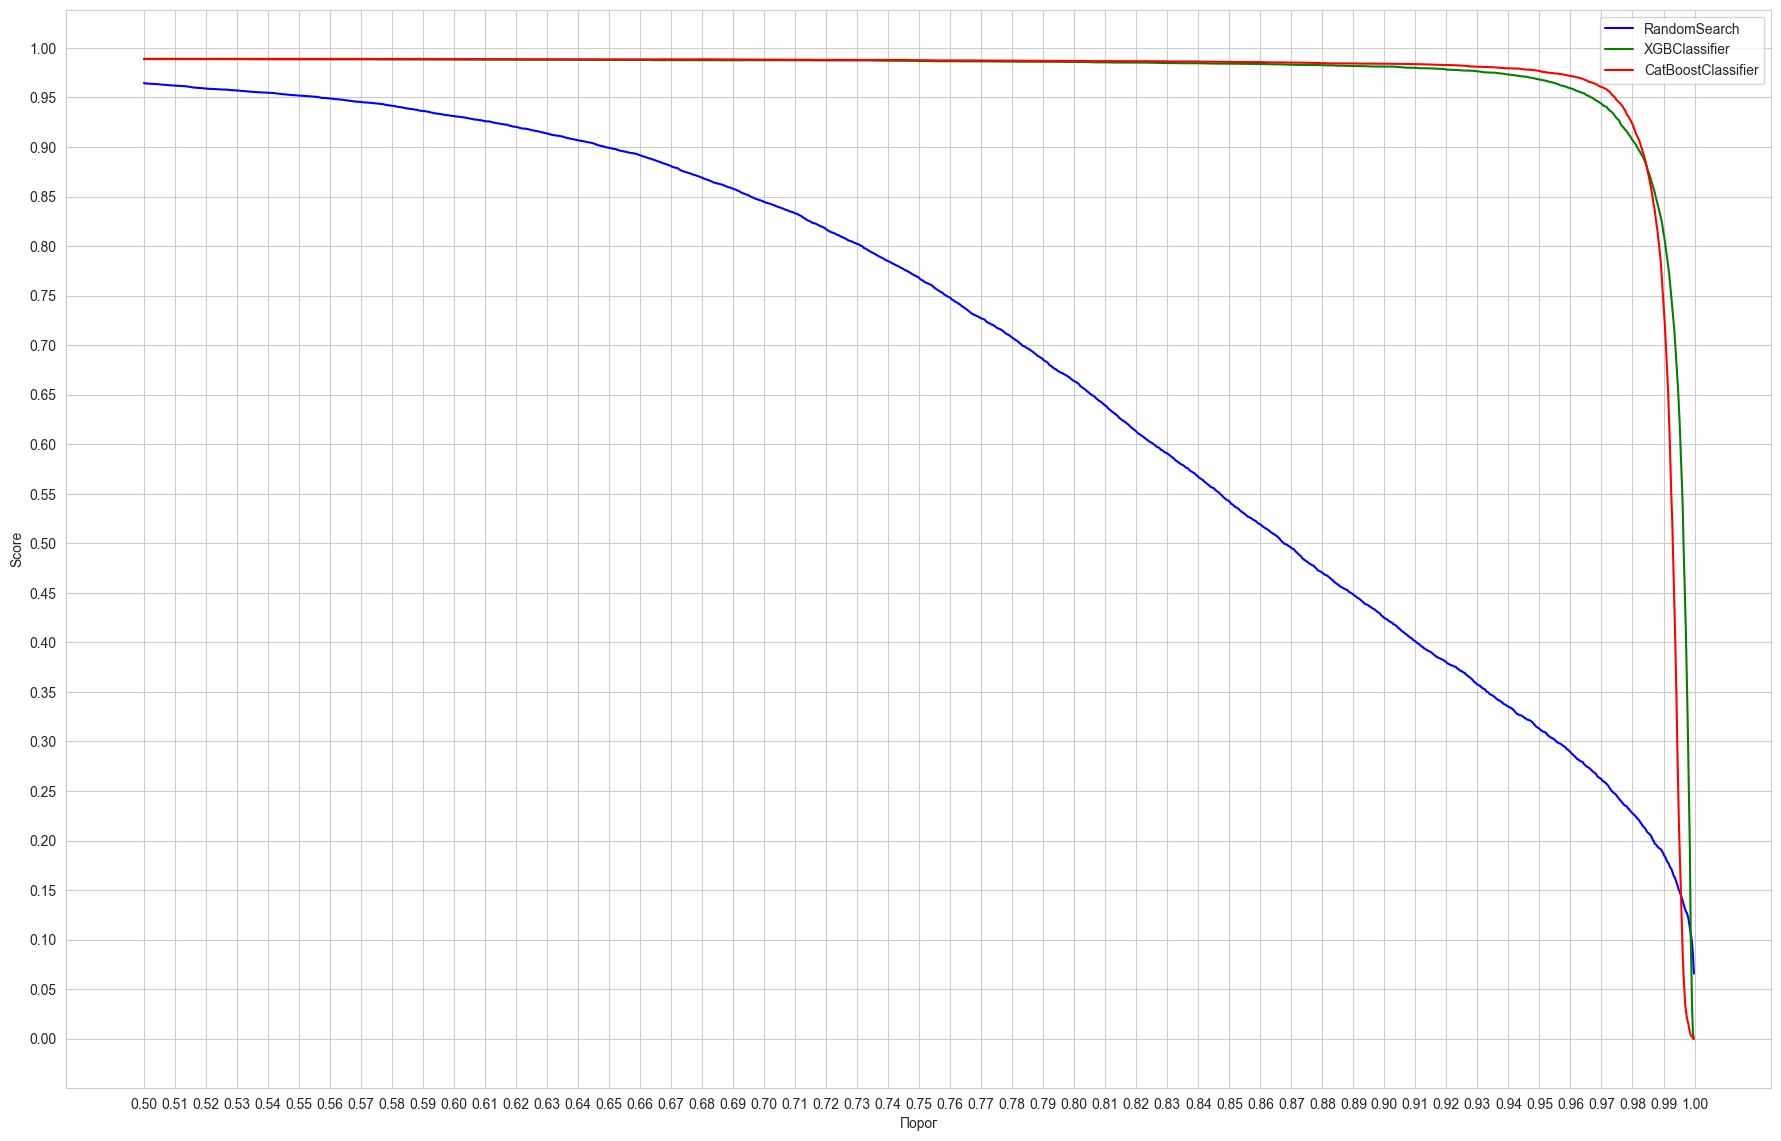

In [212]:
proba_threshold = [round(i, 4) for i in np.linspace(0.5, 1, num=2000, endpoint=False)]

# Инициализация переменных для хранения лучших значений
best_rs_threshold = 0.5
best_rs_f1 = 0

best_xgbc_threshold = 0.5
best_xgbc_f1 = 0

best_catboost_threshold = 0.5
best_catboost_f1 = 0

# Создаем массивы порогов и результатов метрики f1
thresholds = []
rs_scores = []
xgbc_scores = []
catboost_scores = []

# Изменяем порог
for i in proba_threshold:
    # Обновляем предсказания на основе текущего порога
    predictions['rs_prediction'] = predictions['rs_proba'].apply(lambda x: 1 if x > i else 0)
    predictions['xgbc_prediction'] = predictions['xgbc_proba'].apply(lambda x: 1 if x > i else 0)
    predictions['catboost_prediction'] = predictions['catboost_proba'].apply(lambda x: 1 if x > i else 0)

    # Добавляем текущий порог в массив
    thresholds.append(i)

    # Сохраняем метрики
    current_rs_f1 = f1_score(predictions['actual'], predictions['rs_prediction'])
    current_xgbc_f1 = f1_score(predictions['actual'], predictions['xgbc_prediction'])
    current_catboost_f1 = f1_score(predictions['actual'], predictions['catboost_prediction'])

    # Обновляем лучшие значения
    if current_rs_f1 > best_rs_f1:
        best_rs_f1 = current_rs_f1
        best_rs_threshold = i

    if current_xgbc_f1 > best_xgbc_f1:
        best_xgbc_f1 = current_xgbc_f1
        best_xgbc_threshold = i

    if current_catboost_f1 > best_catboost_f1:
        best_catboost_f1 = current_catboost_f1
        best_catboost_threshold = i

    # Добавляем текущие значения метрик в списки
    rs_scores.append(current_rs_f1)
    xgbc_scores.append(current_xgbc_f1)
    catboost_scores.append(current_catboost_f1)

# После цикла сохраняем результаты
best_thresholds = {
    'RandomSearch': (best_rs_threshold, best_rs_f1),
    'XGBClassifier': (best_xgbc_threshold, best_xgbc_f1),
    'CatBoostClassifier': (best_catboost_threshold, best_catboost_f1)
}

print("Лучшие пороги и F1-score:")
for model, (thresh, f1) in best_thresholds.items():
    print(f"{model}: порог = {thresh:.4f}, F1 = {f1:.4f}")

# Визуализация
fig, ax = plt.subplots(figsize=(22, 14))

sns.lineplot(x=thresholds, y=rs_scores,
             legend=True, label='RandomSearch',
             color='blue', ax=ax)
sns.lineplot(x=thresholds, y=xgbc_scores,
             label='XGBClassifier',
             color='green', ax=ax)
sns.lineplot(x=thresholds, y=catboost_scores,
             label='CatBoostClassifier',
             color='red', ax=ax)

ax.set_ylabel('Score')
ax.set_yticks(np.arange(0, 1.01, 0.05))

ax.set_xlabel('Порог')
ax.set_xticks(np.arange(0.5, 1.01, 0.01))

plt.show()

In [213]:
# proba_threshold = [round(i, 4) for i in np.linspace(0.5, 1, num=2000, endpoint=False)]
#
# # Создаем массивы порогов и результатов метрики f1
# thresholds = []
# f1_scores = []
# precision_scores = []
# recall_scores = []
#
# # Изменяем порог
# for i in proba_threshold:
#     predictions['prediction'] = predictions['rs_proba'].apply(lambda x: 1 if x < i else 0)
#
#     thresholds.append(i)
#
#     f1_scores.append(f1_score(predictions['actual'], predictions['prediction']))
#     precision_scores.append(precision_score(predictions['actual'], predictions['prediction']))
#     recall_scores.append(recall_score(predictions['actual'], predictions['prediction']))
#
# fig, ax = plt.subplots(figsize=(22, 14))
#
# sns.lineplot(x=thresholds, y=f1_scores,
#              legend=True, label='f1_score',
#              color='blue', ax=ax)
# sns.lineplot(x=thresholds, y=precision_scores,
#              label='precision_score',
#              color='green', ax=ax)
# sns.lineplot(x=thresholds, y=recall_scores,
#              label='recall_score',
#              color='red', ax=ax)
#
# ax.set_ylabel('Score')
# ax.set_yticks(np.arange(0, 1.01, 0.05))
#
# ax.set_xlabel('Порог')
# ax.set_xticks(np.arange(0.5, 1.01, 0.01))
#
# plt.show()
# # plt.title('Зависимость потерь в млн рублей от выбранного порога');

### Вывод:

После применения RandomizedSearchCV лучшей моделью оказалась `XGBClassifier`, со следующими параметрами:
- `preprocessor__num`: 'passthrough',
- `subsample`: 0.8,
- `reg_lambda`: 1,
- `reg_alpha`: 0.1,
- `n_estimators`: 200,
- `max_depth`: 6,
- `learning_rate`: 0.01,
- `colsample_bytree`: 0.8,

Точность метрики `f1_score` составила `0.951` на тренировочной и валидационной выборках. Метрика отличается на 0.0001, что говорит о том, что модель хорошо обучилась

## Анализ важности признаков

In [214]:
# Получаем обученную модель из OptunaSearchCV
best_model = catboost_optuna_cv.best_estimator_

# Создаем объяснитель SHAP для модели CatBoost
explainer = shap.TreeExplainer(best_model)

# Вычисляем SHAP-значения для тренировочных данных
shap_values = explainer(X_train)

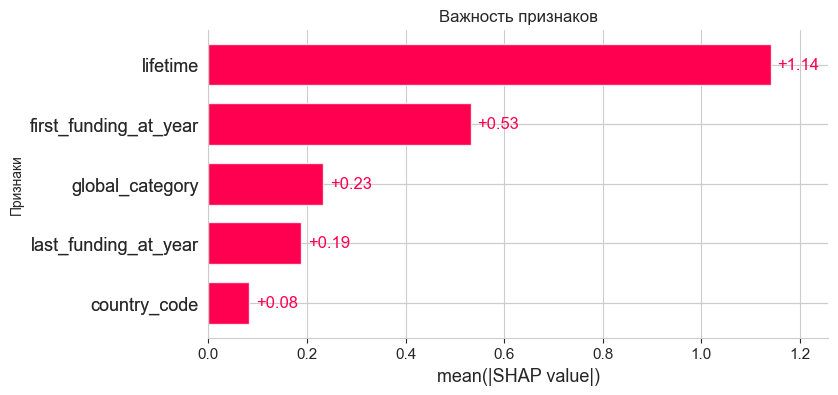

In [215]:
# Выводим график важности признаков
shap.plots.bar(shap_values, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel('Признаки')
ax.set_title('Важность признаков')
plt.show()

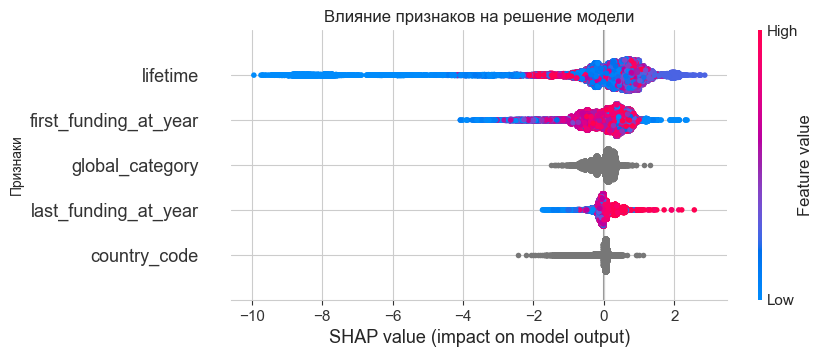

In [216]:
shap.plots.beeswarm(shap_values, max_display=15, show=False)
fig, ax = plt.gcf(), plt.gca()

ax.set_ylabel('Признаки')
ax.set_title('Влияние признаков на решение модели')
plt.show()

## Предсказания модели

In [217]:
predictions

,actual,rs_proba,xgbc_proba,catboost_proba,rs_prediction,xgbc_prediction,catboost_prediction
0,1,0.733804,0.996542,0.993078,0,0,0
1,1,0.713154,0.979736,0.987925,0,0,0
2,1,0.496126,0.675840,0.850312,0,0,0
3,1,0.744228,0.993224,0.986420,0,0,0
4,1,0.647827,0.972608,0.982203,0,0,0
...,...,...,...,...,...,...,...
12652,1,0.684863,0.997661,0.991055,0,0,0
12653,1,0.822460,0.999202,0.993323,0,0,0
12654,1,0.820629,0.960342,0.989192,0,0,0
12655,1,0.750237,0.991309,0.979334,0,0,0


In [218]:
X_test = test_df_processed
X_test

,country_code,lifetime,global_category,first_funding_at_year,last_funding_at_year
0,NIC,3501,Clean Technology,2009,2009
1,USA,2717,Hospitality,2010,2010
2,LUX,1295,Finance,2014,2014
3,USA,4748,Software,2005,2010
4,CAN,6209,Software,2007,2007
...,...,...,...,...,...
13120,USA,2267,Recruiting,2012,2012
13121,USA,2192,Software,2013,2013
13122,USA,2922,Design,2008,2011
13123,USA,1386,Advertising Exchanges,2014,2014


In [219]:
# Проверка для колонки 'category_list'
train_categories = X_train['global_category'].unique()
test_categories = X_test['global_category'].unique()

new_categories = set(test_categories) - set(train_categories)
print(f"Новые категории в тесте: {new_categories}")

Новые категории в тесте: {'Experience Design', 'Homeless Shelter', 'Fmcg', 'Subscription Businesses', 'Private School', 'Gift Registries', 'SNS', 'Social Buying', 'Mobile Shopping', 'RFID', 'Impact Investing', 'Surveys', 'Flash Sales', 'GreenTech', 'Darknet', 'Senior Health', 'Baby Boomers', 'Meeting Software', 'Testing', 'EDA Tools', 'Gay & Lesbian', 'Direct Advertising', 'Logistics Company', 'Usability', 'Musicians', 'Vacation Rentals', 'Realtors', 'Group Email', 'Real Estate Investors', 'Mens Specific'}


In [220]:
set(X_valid.columns) - set(X_test.columns)

set()

In [221]:
X_test['global_category'] = X_test['global_category'].fillna(X_test['global_category'].mode()[0])
X_test

,country_code,lifetime,global_category,first_funding_at_year,last_funding_at_year
0,NIC,3501,Clean Technology,2009,2009
1,USA,2717,Hospitality,2010,2010
2,LUX,1295,Finance,2014,2014
3,USA,4748,Software,2005,2010
4,CAN,6209,Software,2007,2007
...,...,...,...,...,...
13120,USA,2267,Recruiting,2012,2012
13121,USA,2192,Software,2013,2013
13122,USA,2922,Design,2008,2011
13123,USA,1386,Advertising Exchanges,2014,2014


In [222]:
submission = pd.DataFrame({
    'name': test_df['name'],
    'proba':catboost_optuna_cv.best_estimator_.predict_proba(X_test)[:, 1]
})

submission

,name,proba
0,Crystalsol,0.988103
1,JBI Fish & Wings,0.987549
2,COINPLUS,0.975609
3,Imagine Communications,0.988962
4,DNA13,0.984367
...,...,...
13120,Jymob,0.994414
13121,GlobaTrek,0.992089
13122,Inkd.com,0.960316
13123,AdWill,0.986675


In [223]:
best_thresholds

{'RandomSearch': (0.5, 0.9643855058322615),
 'XGBClassifier': (0.5065, 0.988763073731524),
 'CatBoostClassifier': (0.5155, 0.9890783509605008)}

In [224]:
submission['status'] = submission['proba'].apply(lambda x: 'operating' if x > best_thresholds['CatBoostClassifier'][0] else 'closed')
submission = submission[['name', 'status']]
submission

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [225]:
submission.to_csv('submission.csv', index=False)